<a href="https://colab.research.google.com/github/hikaru122700/kaggle-pub/blob/GCI-titanic/25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic
![](https://i.imgur.com/rRFchA8.png)

## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・提出

　機械学習を用いたデータ分析では多くの場合、上の目次に示すような工程で問題に取り組みます。ただしこの順番に沿って一方向的に進んでいくのではなく、前後の工程を行ったり来たりしながら作業は進んでいきます。このような工程に関しては、Mark Peng氏による"General Tips for participating Kaggle Competitions"という講演資料で示されたフローチャート（下図）がわかりやすいです。またKaggleそのものについての解説は、Sergey Yurgenson氏による"Kaggle and Data Science"がわかりやすいでしょう。

"General Tips for participating Kaggle Competitions" : https://www.slideshare.net/markpeng/general-tips-for-participating-kaggle-competitions

"Kaggle and Data Science" : https://www.slideshare.net/hijiki_s/kaggle-and-data-science

![](https://image.slidesharecdn.com/kagglesharingmarkpeng20151216finalpresented-151216161621/95/general-tips-for-participating-kaggle-competitions-6-638.jpg?cb=1452565877)

## 0. ライブラリ・データ読み込み  
　まず初めに使用するライブラリを読み込みます。

In [465]:
# このセルを実行したあとどうすればいいかがわからない方は、別途配布している、「GoogleColabにおけるドライブのマウントの仕方」と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [466]:
!pip install optuna
!pip install lightgbm

In [467]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
import optuna
from optuna.samplers import RandomSampler
import lightgbm as lgb_module
from sklearn.metrics import accuracy_score

　次にpandasのread_csv関数を用いて、分析する訓練データ**train.csv**とテストデータ**test.csv**を読み込みます。  
　変数名に与えた**df**は、**DataFrame**を意味しています（変数名は何でも構いません）。テストデータは素直にdf_testと命名したのに対して訓練データはdfとだけ命名したのは、後に説明するホールドアウト法やクロスバリデーションにおいて、さらにdfを擬似的な訓練データdf_trainと擬似的なテストデータdf_validに分割することを見越してのものです。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。

In [468]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
# path = "/content/drive/My Drive/kaggle/titanic/titanic_data/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
if path == "/content/drive/My Drive/kaggle/titanic/titanic_data/":
    df.rename(columns={'Survived':'Perished'}, inplace=True)

In [469]:
print(df.shape)

(891, 12)


## 1. データの概観・分析・前処理
### 1.1 データの概観
　データを見ていく上で、まず初めにデータのサイズを確認してみましょう。

In [470]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


　訓練データの初めの10データを見てみましょう。

In [471]:
df.head(10)

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,1,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,1,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


　変数名の一覧を見てみましょう。

In [472]:
df.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

　これらの変数名を、README.ipynbに示された変数の説明と対応付けておきましょう。  

変数 |定義 |備考  
---|---|---
Perished |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton



### 1.2 データの分析
　次に**EDA**と呼ばれる作業を行います。EDAとは、**Exploratory Data Analysis**の略で、日本語では**探索的データ分析**と訳されます。EDAでは、データを様々な角度から可視化したり、統計量を見ることで、データの特徴や構造を掴もうと試みます。この工程で得られた知見は機械学習モデルを選ぶ上でも、後に述べる特徴量エンジニアリングにおいても有用です。EDAで得た知見が役立つ理由の一つは、機械学習モデルによって仮定しているデータの特徴が異なることです。EDAによりデータに線型性・独立性・連続性などの特徴が観察できたり、後述の特徴量エンジニアリングでデータを加工することにより顕著な特徴を有した新しいデータを得ることができれば、それに適した機械学習モデルを用いることができます。  
　以下に行うEDAは、"EDA To Prediction (DieTanic)"というAshwini Swain氏によるKaggle Notebookを参考にしたものです。
  
EDA To Prediction (DieTanic)：https://www.kaggle.com/ash316/eda-to-prediction-dietanic

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜならほとんどの機械学習モデルの実装は欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。

In [473]:
df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [474]:
df_test.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


　**Age**、**Fare**, **Cabin**、**Embarked**の値の一部が欠損していることがわかりました。これらには後で対処することとします。  

　次に生存者の割合をみてみましょう。

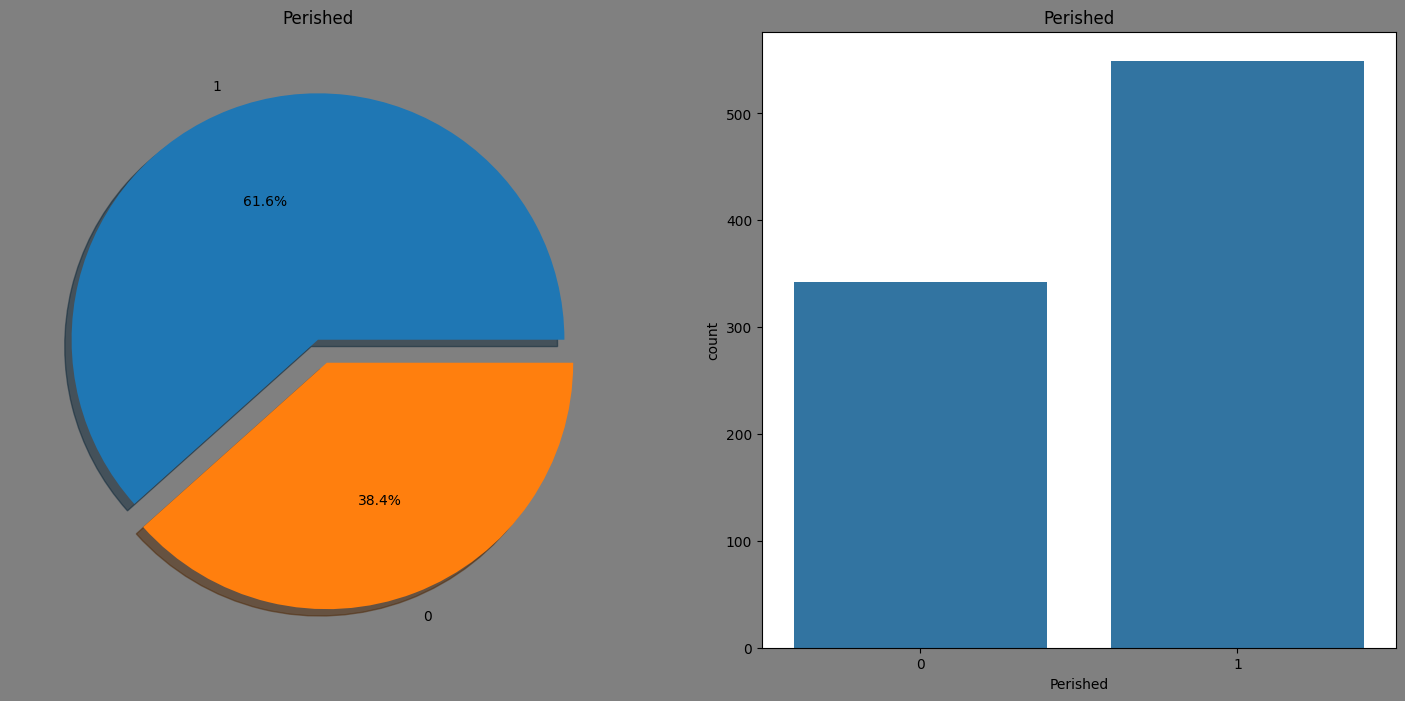

In [475]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Perished')
ax[0].set_ylabel('')
sns.countplot(x='Perished',data=df,ax=ax[1])
ax[1].set_title('Perished')
plt.show()

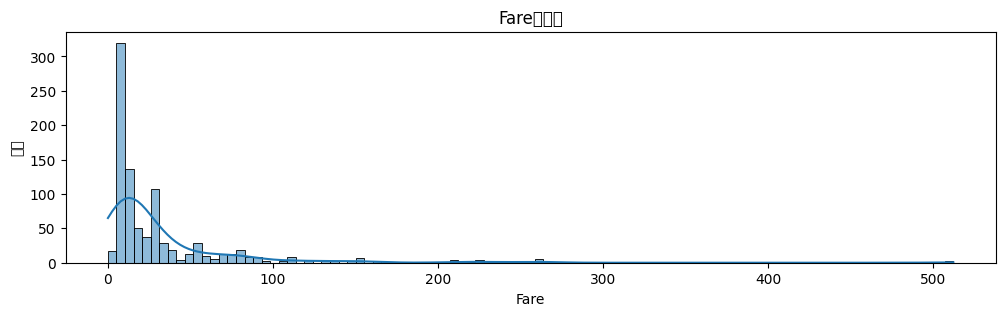

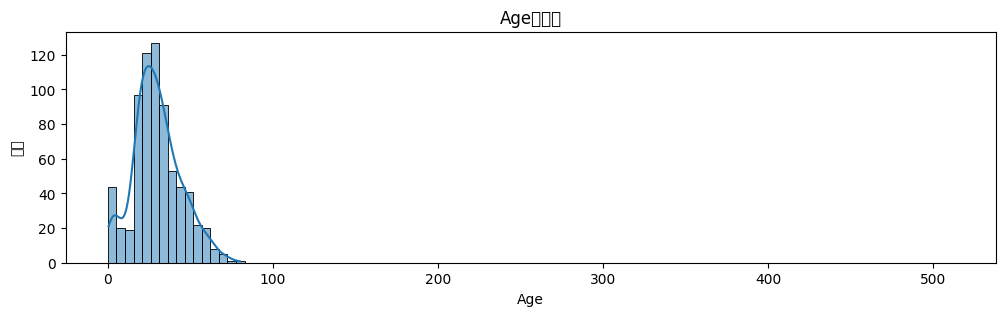

In [476]:
numerical_features = ["Fare", "Age"]
num_bins = 100
min_value = df[numerical_features].min().min()
max_value = df[numerical_features].max().max()
bins = np.linspace(min_value, max_value, num_bins)

for col in numerical_features:
    plt.figure(figsize=(12, 3))
    sns.histplot(df[col], bins=bins, kde=True)
    plt.title(f'{col}の分布')
    plt.xlabel(col)
    plt.ylabel('頻度')
    plt.show()
    print()

生存率は38.4%であることがわかりました。分析対象となるデータには様々ありますが、一つの分類に**均衡データ**/**不均衡データ**というものがあります。不均衡データとは、主に予測対象のラベルの分布が著しく偏ったデータのことであり、病気の陽性/陰性などがその代表例です。不均衡データを分析する際には、データの前処理やモデルの構築、評価指標の選び方など様々な点において注意しなければなりません。しかし今回の予測対象であるPerishedは生存:死亡がおよそ4:6と均衡しているので、そうした心配の必要はありません。  

　次にデータの型について見てみましょう。機械学習を用いてデータ分析を行う際には、データの型にも注意が必要です。なぜならほとんどの機械学習モデルの実装はカテゴリカル変数を含むデータに対して学習や予測ができず、エラーとなってしまうからです。  
　データの型には大別して**数値データ**と**カテゴリカルデータ**があります。他にも日付・時間データなどがあったり、連続値データ/離散値データの区別があったりしますが、ここでは扱いません。数値データは文字通り数値が格納されたデータであり、カテゴリカルデータは主に文字列によってその分類が示されたデータです。ただしデータが数値であっても、その値の大小や順序が意味を持たない場合にはカテゴリカルデータとして扱う必要がある点には注意が必要です。  
　この観点では今回のデータは以下のように分類されます。
- 数値データ：Pclass, Age, SibSp, Parch, Fare
- カテゴリカルデータ：Name, Sex, Ticket, Embarked

　これらのカテゴリカルデータは機械学習モデルで扱えるよう、後で適切に処理します。

　ここからは一つ一つの変数について見ていきましょう。ただし、ここではデモンストレーションとして一部しか扱いません。またデータ分析コンペティションでは、必ずしも全てのEDAを自分で一から行う必要はありません。基本的なEDAは多くの場合Kaggle Notebookとして共有されますし、pandas-profilingなどの便利なライブラリを用いれば済んでしまうからです。しかし他の参加者との差別化を図るには、自らEDAで得た知見を活用する必要があります。また実務においてEDAを肩代わりしてくれる人はいません。これらの理由から、やはり自分である程度のEDAをこなせる必要はあるでしょう。

　まずは**Pclass**（チケットのクラス）について見ていきます。

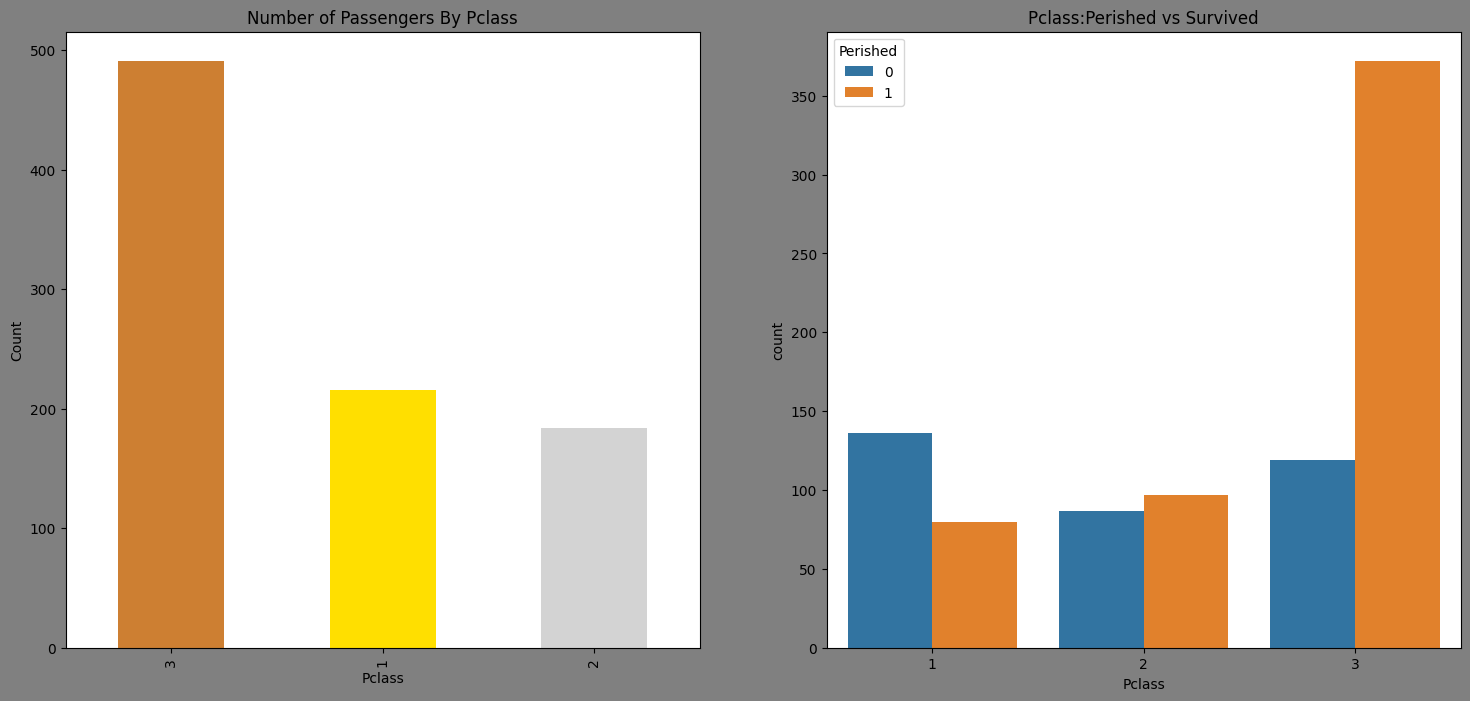

In [477]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Perished',data=df,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

　Pclassごとに人数および死亡率が著しく異なっていることが見て取れます。特にPclass=3は人数が圧倒的に多く、死亡率が著しく高いことがわかります。一方でPclass=1は死亡率が非常に低くなっています。Pclassはチケットのクラスでしたから、ここに見た事実は、Pclassの値が小さいほどチケットのグレードが高いことを直ちに示唆しています。他にはどのような知見が得られるか考えてみましょう。

　次に**Age**（年齢）について見てみます。

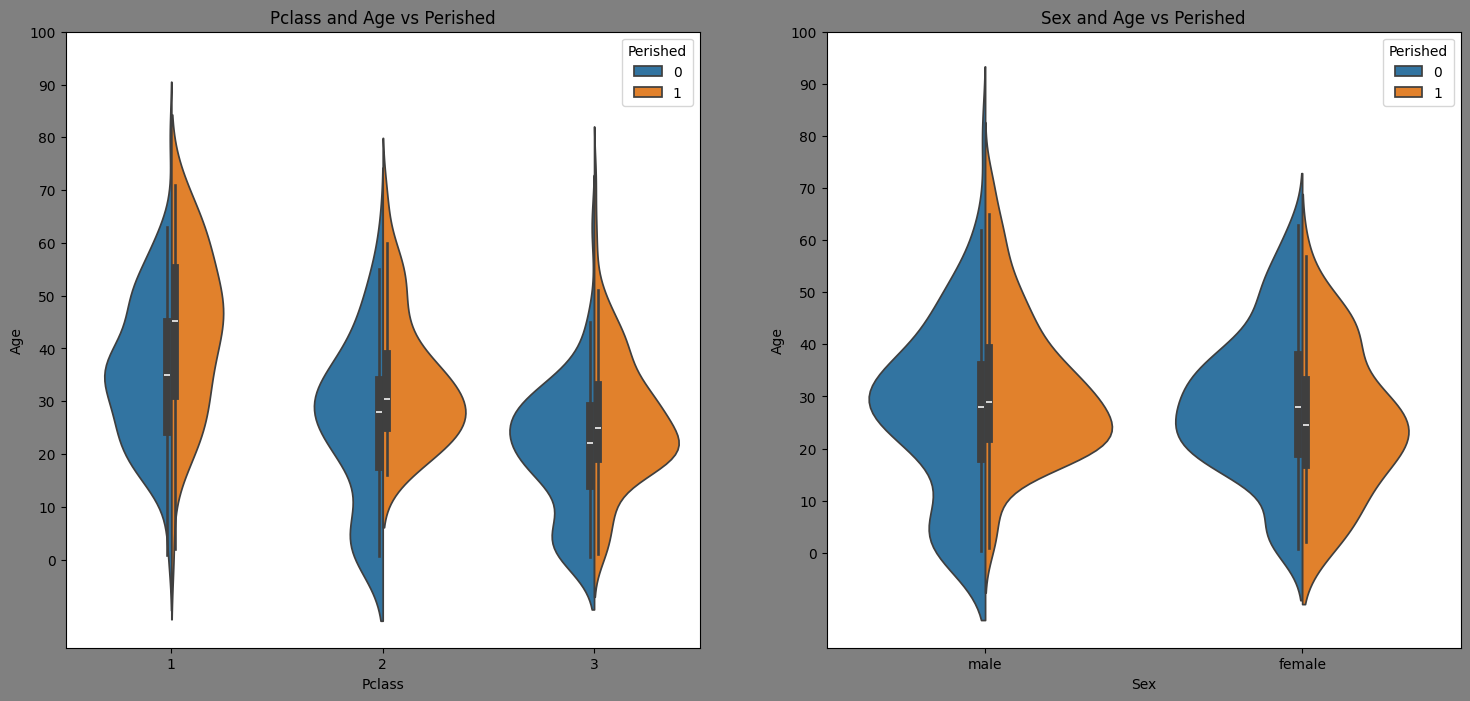

In [478]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
sns.violinplot(x="Pclass",y="Age", hue="Perished", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Perished", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

　このような図を**バイオリン図**と言います。身近なところでは人口推計の男女別年齢分布が似たような図で示されています。この図からどのような知見が得られるでしょうか。最も顕著な傾向の一つは男性の幼年層に見られます。10歳以下の男性は死亡率が著しく低くなっています。この事実はタイタニック号の事故において幼い男の子が優先的に助けられたことを示唆しています。他にはどのような知見が得られるか考えてみましょう。

　最後に**相関行列**の**ヒートマップ**を表示してみましょう。相関行列とは各成分に対応する相関係数を並べた行列のことであり、値の大小に応じて色をつけたものをヒートマップと呼びます。この図を表示することによって、変数間の相関の強さを一目で把握することができます。

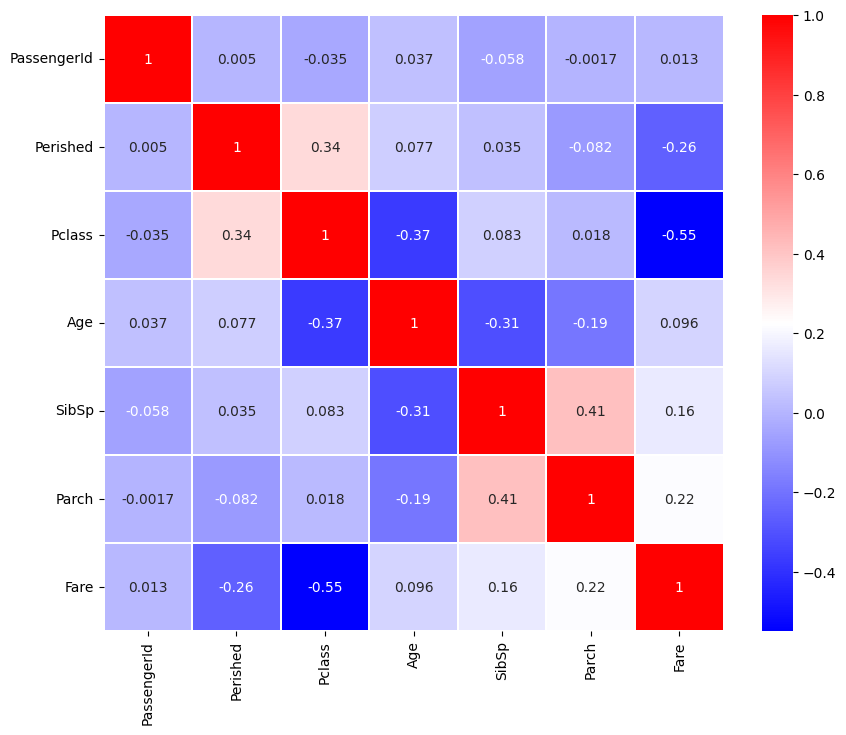

In [479]:
df_numeric = df.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

　この図から、SibSpとParchの値に比較的強い正の相関があることがわかります。SibSpは同乗していた兄弟姉妹・配偶者の数であり、Parchは同乗していた親・子供の数であったので、この事実は理解しやすいでしょう。ここでSibSpの値とParchの値の和をとって「同乗していた家族の人数」という新しい変数を加えるアイデアが得られます。なぜならSibSpとParchという不自然な分類で二つの変数に分割してあるよりも「同乗していた家族の人数」という変数の方が自然である可能性があるからです。

　他にもPclassとFareの値に比較的強い負の相関が見られます。この事実は、先に見たようにPclassの値が小さいほどチケットのグレードが高いという見立てを補強しています。この見立ては正しいと見ていいでしょう。  

　このように相関が強い変数がある場合には注意が必要です。相関の強い変数を機械学習モデルの学習に用いると、一部のモデルでは**多重共線性**という問題が生じます。そのため著しく相関の強い変数がある場合は、その変数のうち一つだけを残して他の変数を削除するといった対策をすることがあります。ここでは相関が強すぎるという程では無いと見て、こうした対策は行いませんが、自分で試してみても良いでしょう。

## 1.3 データの前処理
　ここでは、機械学習モデルが学習できるようにデータの前処理を行なっていきます。

　まずは**欠損値**の補完です。先に見たようにAge、Fare, Cabin、Embarkedの4変数は一部が欠損していました。欠損値の補完には様々な手法があります。平均値や最頻値といった代表値で補完する手法、機械学習モデルで予測して予測値で補完する手法、-9999などの外れ値で補完することによって欠損していたという情報を保持する手法などが挙げられます。
  
　AgeとFareは数値データなので安直に平均値で補完してみましょう。この点で改善の余地は非常に大きいです。例えばNameに含まれる'Miss'と'Mrs'という敬称で平均年齢にズレがあるだろうことは容易に想像できます。余裕があればこのアイデアを実装してみたり、別のアイデアを考えてみたりしてみましょう。名案を思いついたが実装までは難しいという場合でも、他の受講生に実装のアドバイスを求めたり、そのアイデアについて議論してみたりしましょう。

#ageに関して

ageは最頻値で補完する。

In [480]:
age = pd.concat([df['Age'], df_test['Age']])
fare = pd.concat([df['Fare'], df_test['Fare']])
age_mode = age.mode()[0]
print(age_mode)
df['Age'].fillna(age_mode, inplace=True)
df_test['Age'].fillna(age_mode, inplace=True)

df['Fare'].fillna(fare.mean(), inplace=True)
df_test['Fare'].fillna(fare.mean(), inplace=True)

df.isnull().sum()
print(df_test.isnull().sum())

24.0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


　このように、とりあえずAgeの欠損値を補完することができました。  
　次はCabinですが、欠損値の数が全体の8割近いので、削除してしまいます。削除しないでどうにか補完する方法を考えてみても良いでしょう。欠損しているかしていないかという情報も有意であることがあるので、そのような情報を保つような補完の方法でも良いかもしれません。

In [481]:
df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


　このようにCabinの欠損にも対処できました。  
　最後にEmbarkedの欠損値です。まずEmbarkedの分布を見てみましょう。

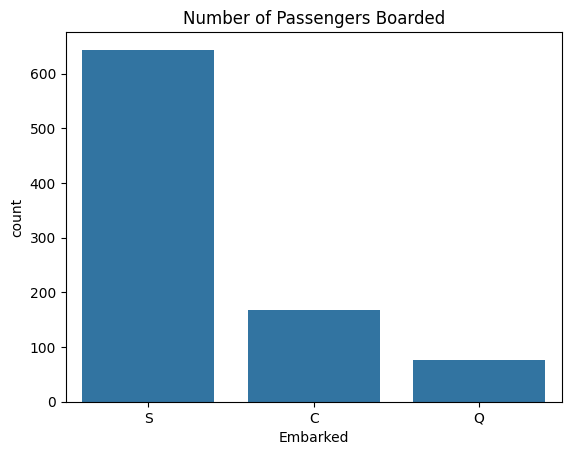

In [482]:
sns.countplot(x='Embarked',data=df)
plt.title('Number of Passengers Boarded')
plt.show()

　Embarked(乗船した港)は'S'(Southampton)が圧倒的に多いので、Embarkedの二件の欠損値は'S'で補完しておきましょう。

In [483]:
df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [484]:
df.head(20)

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,1,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,1,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,1,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


　こうして全ての欠損値に対処することができました。

　次に**カテゴリカルデータ**を機械学習モデルで扱えるよう処理します。カテゴリカルデータには、Name, Sex, Ticket, Embarkedがありました。  
　まずはName, Ticketについてです。これらは扱いが難しいためこのデモンストレーションでは削除します。しかしこれはあまり良い判断ではありません。なぜなら前述のように'Miss'や'Mr'といった敬称が有意な情報を持っている可能性があるからです。またファミリーネームから、誰と誰が家族かという情報を得ることができる可能性もあります。Ticketに関しても同様になんらかの情報が得られる可能性は十分あります。余裕があればEDAで手がかりを探してみたり、アイデアを実装してみたりしましょう。

In [485]:
# df.drop('Name', axis=1, inplace=True)
# df_test.drop('Name', axis=1, inplace=True)

# df.drop('Ticket', axis=1, inplace=True)
# df_test.drop('Ticket', axis=1, inplace=True)

# df.columns

　次にSex（性別）です。このような二値のカテゴリカル変数は、一方を0、もう一方を1とすることで数値化することができます。ここでは男性を0、女性を1としておきます。

In [486]:
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,1,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S


　最後にEmbarked（乗船した港）です。先ほど見たようにEmbarkedには'S', 'C', 'Q'の3種類の値があります。男女を0と1で置き換えたように、'S', 'C', 'Q'を0, 1, 2で置き換えれば良いでしょうか？答えは一般には"No"です。なぜなら'S'<'C'<'Q'のような大小関係は存在せず、'Q'-'C'='C'-'S'のように値の間隔が意味をもつ訳でもないからです。ではどのようにEmbarkedというカテゴリカルデータを数値化すれば良いのでしょう。その一つの手法はOne-Hot Encodingです。One-Hot Encodingとは、下図のようにしてカテゴリカルデータを0と1に変換する手法です。

![](https://blog.datascienceheroes.com/content/images/2019/07/one-hot-encoding.png)

In [487]:
embarked = pd.concat([df['Embarked'], df_test['Embarked']])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,C,Q,S
0,1,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,False,False,True
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,True,False,False
2,3,0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,False,False,True
4,5,1,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,False,False,True


In [488]:
from collections import Counter
family_name: Counter[int] = Counter()
family_num: Counter[int] = Counter()
for i in range(len(df)):
    family_name[df.iloc[i]["Name"].split(",")[0]] += df.iloc[i]["Perished"]
    family_num[df.iloc[i]["Name"].split(",")[0]] += 1

In [489]:
# df["Master"] = False
# df_test["Master"] = False
# for i in range(len(df)):
#     if df.iloc[i]["Name"].find("Master") != -1:
#         df["Master"][i] = True
# for i in range(len(df_test)):
#     if df_test.iloc[i]["Name"].find("Master") != -1:
#         df_test["Master"][i] = True

# print(sum(df["Master"])/len(df))



In [490]:
# df["Family_Perished"] = -1
# for i in range(len(df)):
#     if family_num[df.iloc[i]["Name"].split(",")[0]] >= 2:
#         df["Family_Perished"][i] = (family_name[df.iloc[i]["Name"].split(",")[0]]-df.iloc[i]["Perished"]) / family_num[df.iloc[i]["Name"].split(",")[0]]

# df_test["Family_Perished"] = 0.5
# for i in range(len(df_test)):
#     if family_num[df_test.iloc[i]["Name"].split(",")[0]] >= 2:
#         df_test["Family_Perished"][i] = (family_name[df.iloc[i]["Name"].split(",")[0]]-df.iloc[i]["Perished"]) / family_num[df_test.iloc[i]["Name"].split(",")[0]]

df.drop('Name', axis=1, inplace=True)
df_test_name = df_test['Name']
df_test.drop('Name', axis=1, inplace=True)
df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,C,Q,S
0,1,1,3,0,22.0,1,0,A/5 21171,7.2500,False,False,True
1,2,0,1,1,38.0,1,0,PC 17599,71.2833,True,False,False
2,3,0,3,1,26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,4,0,1,1,35.0,1,0,113803,53.1000,False,False,True
4,5,1,3,0,35.0,0,0,373450,8.0500,False,False,True


In [491]:
df['Family'] = df['SibSp'] + df['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df.head(10)

,PassengerId,Perished,Pclass,Sex,Age,Ticket,Fare,C,Q,S,Family
0,1,1,3,0,22.0,A/5 21171,7.2500,False,False,True,1
1,2,0,1,1,38.0,PC 17599,71.2833,True,False,False,1
2,3,0,3,1,26.0,STON/O2. 3101282,7.9250,False,False,True,0
3,4,0,1,1,35.0,113803,53.1000,False,False,True,1
4,5,1,3,0,35.0,373450,8.0500,False,False,True,0
5,6,1,3,0,24.0,330877,8.4583,False,True,False,0
6,7,1,1,0,54.0,17463,51.8625,False,False,True,0
7,8,1,3,0,2.0,349909,21.0750,False,False,True,4
8,9,0,3,1,27.0,347742,11.1333,False,False,True,2
9,10,0,2,1,14.0,237736,30.0708,True,False,False,1


In [492]:
df["alone"] = [1]*len(df)
df_test["alone"] = [1]*len(df_test)
for i in range(len(df)):
    if df.iloc[i]["Family"] == 0:
        df["alone"][i] = 0
for i in range(len(df_test)):
    if df_test.iloc[i]["Family"] == 0:
        df_test["alone"][i] = 0

In [493]:
df.describe(include = 'all')
df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df.head()

,PassengerId,Perished,Pclass,Sex,Age,Fare,C,Q,S,Family,alone
0,1,1,3,0,22.0,7.2500,False,False,True,1,1
1,2,0,1,1,38.0,71.2833,True,False,False,1,1
2,3,0,3,1,26.0,7.9250,False,False,True,0,0
3,4,0,1,1,35.0,53.1000,False,False,True,1,1
4,5,1,3,0,35.0,8.0500,False,False,True,0,0


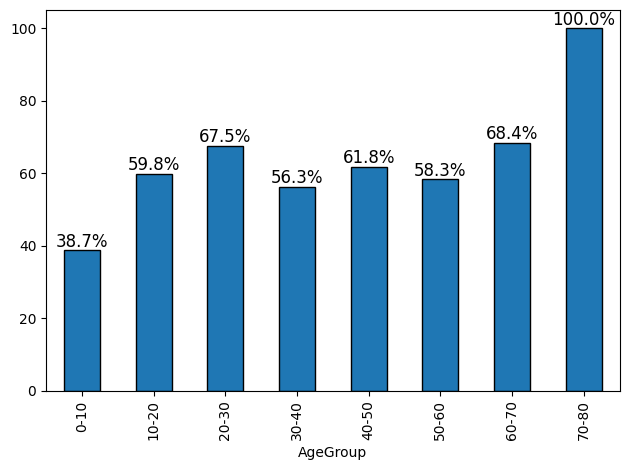

In [494]:
# 年齢をビンに分ける
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# 各ビンでの生存率を計算
age_survival = df.groupby('AgeGroup')['Perished'].mean() * 100  # パーセンテージに変換
# バーグラフの作成
age_survival.plot(kind='bar', edgecolor='black')
# 各バーに生存率の値を表示
for index, value in enumerate(age_survival):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', fontsize=12)

# グラフを表示
plt.tight_layout()
plt.show()
df.drop('AgeGroup', axis=1, inplace=True)


In [495]:
# df["Is_male"] = 0
# df_test["Is_male"] = 0
# for i in range(len(df)):
#     if df.iloc[i]["Sex"] == 0 and df.iloc[i]["Age"] >= 17:
#         df["Is_male"][i] = 1
# for i in range(len(df_test)):
#     if df_test.iloc[i]["Sex"] == 0 and df_test.iloc[i]["Age"] >= 17:
#         df_test["Is_male"][i] = 1

# df.drop('Sex', axis=1, inplace=True)
# df_test.drop('Sex', axis=1, inplace=True)
# df.drop("Age", axis=1, inplace=True)
# df_test.drop("Age", axis=1, inplace=True)

In [496]:
# df.drop('alone', axis=1, inplace=True)
# df_test.drop('alone', axis=1, inplace=True)

In [497]:
df.columns, df_test.columns

(Index(['PassengerId', 'Perished', 'Pclass', 'Sex', 'Age', 'Fare', 'C', 'Q',
        'S', 'Family', 'alone'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'C', 'Q', 'S', 'Family',
        'alone'],
       dtype='object'))

　このようにして、全てのカテゴリカルデータを処理することができました。

## 2. ベースラインモデルの構築

　ここでようやくモデルの構築に入ります。モデルの構築においては、まずベースラインとなるモデルを作成することが多いです。ベースラインモデルは、機械学習モデルが学習できる形にデータが整形されているか確認することや、改良されたモデルと比較して改良の効果を評価することが主な目的です。ベースラインモデルは、あまり学習に時間のかからないモデルを用います。ここでは、ベースラインモデルとしてよく用いられるランダムフォレストを使用します。ランダムフォレストのアルゴリズムについては講義で学びますが、簡単に説明すると複数の決定木の多数決によって予測を行う機械学習モデルになります。  
　まずdfとdf_testを**説明変数**と**目的変数**に分けます。
- 説明変数：モデルの学習に使用する変数、今回の問題ではPassengerId, Perished以外の変数
- 目的変数：予測対象の変数, 今回の問題ではPerished

　ここでスライスしたdfとdf_testを.valuesとしてnumpy.ndarray型に変換しているのは、機械学習モデルの実装によってはこの型のデータしか受け付けないからです。

In [498]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

　機械学習モデルにとって最大の障害の一つは**過学習**です。過学習とは機械学習モデルが訓練データを学習する際に、訓練データに対して正しい予測を与えようとするあまり、訓練データにしか良い予測を与えられず、テストデータや他のデータに対して役に立たなくなってしまう現象のことです。

　この現象を回避するための手法の一つに**ホールドアウト法**があります。ホールドアウト法では、与えられた訓練データをさらに擬似訓練データと擬似テストデータに分割し、機械学習モデルを擬似訓練データで学習させます。その上で、擬似訓練データに対する予測精度と擬似テストデータに対する予測精度を比較して、二つの値に大きな解離が見られる場合には過学習が発生していると判断し、過学習を抑えるよう修正を加えます。  

　今回は7:3で元の訓練データを分割して、擬似訓練データ(X_train, y_train)と擬似テストデータ(X_valid, y_valid)とします。変数名は何でも構いませんが、ここで用いたvalidとはvalidation(検証)の略です。これは擬似テストデータをモデルの予測精度の検証に用いることに由来します。

　データの分割には、scikit-learnのtrain_test_split関数を使用しますが、分割はランダムに行われるため、再現性を保つためには乱数生成のシード値を引数random_stateで指定する必要があります。この値を42とする例が海外を中心に散見されるのは、この数字が、有名なSF作品「銀河ヒッチハイク・ガイド」で「生命、宇宙、そして万物についての究極の疑問の答え」とされているからだそうです。

　ホールドアウト法の拡張には、**クロスバリデーション**があります。クロスバリデーションについては後で改めて解説します。

In [499]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [500]:
def objective_rfc(trial):
     # ハイパーパラメータの提案
    n_estimators = trial.suggest_int("n_estimators", 100, 400)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # モデルの初期化
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )

    # K-Fold クロスバリデーションの設定
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X))


    # 各Foldでの学習と予測
    for train_idx, valid_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        # モデルの訓練
        model.fit(X_tr, y_tr)

        # バリデーションデータでの予測
        oof_predictions[valid_idx] = model.predict(X_val)

    # 正解率の計算
    accuracy = accuracy_score(y, oof_predictions)

    return accuracy  # Optuna はこの値を最大化します

In [502]:
# Create an Optuna study
study = optuna.create_study(
    direction='maximize',
)

# Optimize the study
study.optimize(objective_rfc, n_trials=56)

# Display the best results
print(f"Best objective value (Accuracy): {study.best_value}")
print(f"Best parameters: {study.best_params}")
print("-" * 50)

# Retrieve the best parameters
best_params = study.best_params
best_params['random_state'] = 0  # For reproducibility

# Initialize the final model with the best parameters
rfc = RandomForestClassifier(**best_params)

# Fit the final model on the entire dataset
rfc.fit(X_train, y_train)

[I 2024-11-14 08:17:57,854] A new study created in memory with name: no-name-f55ad84e-5050-495a-92fb-8438ce879846
[I 2024-11-14 08:18:00,778] Trial 0 finished with value: 0.8260381593714927 and parameters: {'n_estimators': 203, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8260381593714927.
[I 2024-11-14 08:18:03,504] Trial 1 finished with value: 0.8249158249158249 and parameters: {'n_estimators': 201, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8260381593714927.
[I 2024-11-14 08:18:06,247] Trial 2 finished with value: 0.819304152637486 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8260381593714927.
[I 2024-11-14 08:18:09,995] Trial 3 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 254, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 8}. Best is trial 0 with value

Best objective value (Accuracy): 0.8305274971941639
Best parameters: {'n_estimators': 165, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 1}
--------------------------------------------------


RandomForestClassifier(max_depth=17, min_samples_split=20, n_estimators=165,
                       random_state=0)

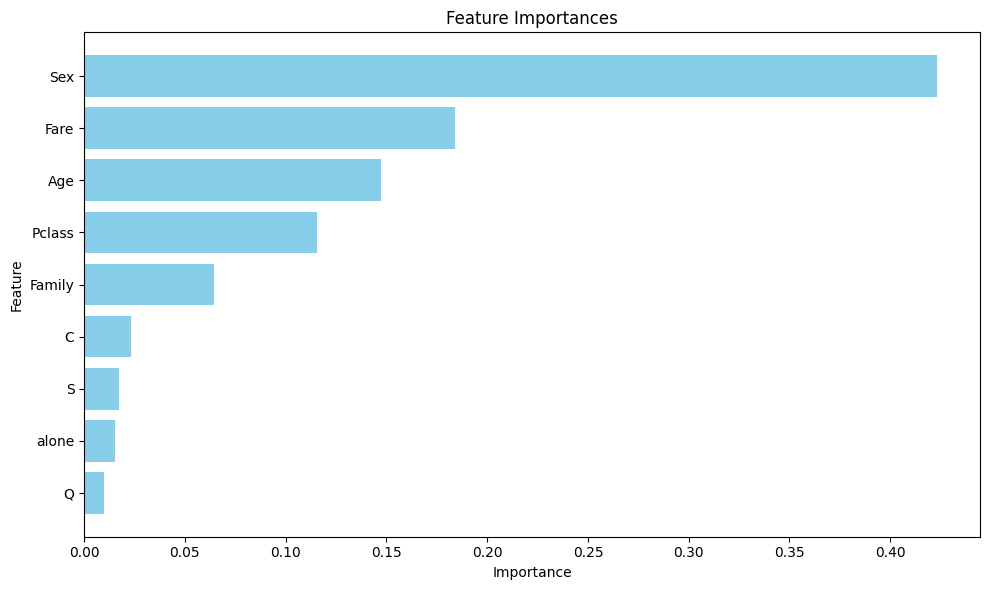

In [503]:
# 特徴量の重要度を取得
importances = rfc.feature_importances_
feature_names = df.iloc[:, 2:].columns

# データフレームにまとめる
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 重要度でソート
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [504]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print('Logistic Regression \n')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

Logistic Regression 

Train Score: 0.799
 Test Score: 0.806


　次に多層パーセプトロンモデルです。

In [505]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=0)
mlpc.fit(X_train, y_train)

print('Multilayer Perceptron \n')
print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

Multilayer Perceptron 

Train Score: 0.828
 Test Score: 0.802


#  K近傍法でも試してみる

参考にしたサイトは最後に記載してある

In [506]:
n_neighbors = 3
# モデルの学習
knc = KNeighborsClassifier(n_neighbors=n_neighbors)
knc.fit(X_train, y_train)

print('KNeighborsClassifier \n')
print('Train Score: {}'.format(round(knc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(knc.score(X_valid, y_valid), 3)))
# テストデータの分類予測
# y_pred = knc.predict(x)

KNeighborsClassifier 

Train Score: 0.831
 Test Score: 0.72


In [507]:
def objective_gbc(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 400)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)



    # モデルの初期化
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # K-Fold クロスバリデーションの設定
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X))


    # 各Foldでの学習と予測
    for train_idx, valid_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        # モデルの訓練
        model.fit(X_tr, y_tr)

        # バリデーションデータでの予測
        oof_predictions[valid_idx] = model.predict(X_val)

    # 正解率の計算
    accuracy = accuracy_score(y, oof_predictions)

    return accuracy  # Optuna はこの値を最大化します

In [508]:
# Create an Optuna study
study = optuna.create_study(
    direction='maximize',
)

# Optimize the study
study.optimize(objective_gbc, n_trials=50)

# Display the best results
print(f"Best objective value (Accuracy): {study.best_value}")
print(f"Best parameters: {study.best_params}")
print("-" * 50)

# Retrieve the best parameters
best_params = study.best_params
best_params['random_state'] = 0  # For reproducibility

# Initialize the final model with the best parameters
gbc = GradientBoostingClassifier(**best_params)
# Fit the final model on the entire dataset
gbc.fit(X_train, y_train)

[I 2024-11-14 08:19:55,906] A new study created in memory with name: no-name-eb359aea-9974-4a9f-9c69-81dc067e2509
[I 2024-11-14 08:19:59,422] Trial 0 finished with value: 0.7901234567901234 and parameters: {'n_estimators': 180, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7901234567901234.
[I 2024-11-14 08:20:05,636] Trial 1 finished with value: 0.7912457912457912 and parameters: {'n_estimators': 378, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7912457912457912.
[I 2024-11-14 08:20:10,975] Trial 2 finished with value: 0.7890011223344556 and parameters: {'n_estimators': 277, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7912457912457912.
[I 2024-11-14 08:20:15,808] Trial 3 finished with value: 0.7789001122334456 and parameters: {'n_estimators': 275, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 1 with va

Best objective value (Accuracy): 0.8294051627384961
Best parameters: {'n_estimators': 203, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2}
--------------------------------------------------


GradientBoostingClassifier(max_depth=2, min_samples_leaf=2, n_estimators=203,
                           random_state=0)

In [509]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 400)

    # モデルの初期化
    model = XGBClassifier(
        n_estimators=n_estimators,
    )
    # K-Fold クロスバリデーションの設定
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X))


    # 各Foldでの学習と予測
    for train_idx, valid_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        # モデルの訓練
        model.fit(X_tr, y_tr)

        # バリデーションデータでの予測
        oof_predictions[valid_idx] = model.predict(X_val)

    # 正解率の計算
    accuracy = accuracy_score(y, oof_predictions)

    return accuracy  # Optuna はこの値を最大化します

In [510]:
# Create an Optuna study
study = optuna.create_study(
    direction='maximize',
)

# Optimize the study
study.optimize(objective_xgb, n_trials=50)

# Display the best results
print(f"Best objective value (Accuracy): {study.best_value}")
print(f"Best parameters: {study.best_params}")
print("-" * 50)

# Retrieve the best parameters
best_params = study.best_params
best_params['random_state'] = 0  # For reproducibility

# Initialize the final model with the best parameters
xgb = GradientBoostingClassifier(**best_params)
# Fit the final model on the entire dataset
xgb.fit(X_train, y_train)

[I 2024-11-14 08:22:51,453] A new study created in memory with name: no-name-7cbefc0d-a400-4810-b54c-25854a89d1fd
[I 2024-11-14 08:22:51,733] Trial 0 finished with value: 0.8069584736251403 and parameters: {'n_estimators': 131}. Best is trial 0 with value: 0.8069584736251403.
[I 2024-11-14 08:22:52,167] Trial 1 finished with value: 0.7957351290684624 and parameters: {'n_estimators': 314}. Best is trial 0 with value: 0.8069584736251403.
[I 2024-11-14 08:22:52,585] Trial 2 finished with value: 0.7946127946127947 and parameters: {'n_estimators': 329}. Best is trial 0 with value: 0.8069584736251403.
[I 2024-11-14 08:22:52,745] Trial 3 finished with value: 0.8080808080808081 and parameters: {'n_estimators': 103}. Best is trial 3 with value: 0.8080808080808081.
[I 2024-11-14 08:22:53,150] Trial 4 finished with value: 0.7968574635241302 and parameters: {'n_estimators': 332}. Best is trial 3 with value: 0.8080808080808081.
[I 2024-11-14 08:22:53,608] Trial 5 finished with value: 0.794612794612

Best objective value (Accuracy): 0.8080808080808081
Best parameters: {'n_estimators': 103}
--------------------------------------------------


GradientBoostingClassifier(n_estimators=103, random_state=0)

In [511]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# データの標準化（タイポ修正）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
# X_test_scaled = scaler.transform(df_test)  # 実際のdf_testを使用

# モデルの構築
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 出力層を1つに変更

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 損失関数をbinary_crossentropyに変更
              metrics=['accuracy'])

# モデルの訓練
history = model.fit(X_train_scaled, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=1)

# バリデーションデータに対する予測（確率）
va_pred_prob = model.predict(X_valid_scaled)
print(va_pred_prob)
# 確率をクラスラベルに変換（0または1）
va_pred = (va_pred_prob > 0.5).astype(int).reshape(-1)

# 正解率の計算
accuracy = accuracy_score(y_valid, va_pred)
print(f"va_predのスコアは{accuracy}\n")
NN = model
X_test_scaled = scaler.transform(X_test)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4781 - loss: 0.7118 - val_accuracy: 0.7799 - val_loss: 0.5888
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7853 - loss: 0.5693 - val_accuracy: 0.8060 - val_loss: 0.5126
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7889 - loss: 0.5112 - val_accuracy: 0.8097 - val_loss: 0.4705
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8048 - loss: 0.4669 - val_accuracy: 0.7948 - val_loss: 0.4459
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8134 - loss: 0.4303 - val_accuracy: 0.7985 - val_loss: 0.4357
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7984 - loss: 0.4318 - val_accuracy: 0.8060 - val_loss: 0.4316
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.4388 - val_accuracy: 0.7985 - val_loss: 0.4291
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.4100 - val_accuracy: 0.8097 - val_loss

In [512]:
!pip install catboost


In [513]:
from catboost import CatBoostClassifier
def objective_cat(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    depth = trial.suggest_int("depth", 2, 10)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)


    model = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )


    # K-Fold クロスバリデーションの設定
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X))


    # 各Foldでの学習と予測
    for train_idx, valid_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        # モデルの訓練
        model.fit(X_tr, y_tr)

        # バリデーションデータでの予測
        oof_predictions[valid_idx] = model.predict(X_val)

    # 正解率の計算
    accuracy = accuracy_score(y, oof_predictions)

    return accuracy  # Optuna はこの値を最大化します


In [514]:
# Create an Optuna study
study = optuna.create_study(
    direction='maximize',
)

# Optimize the study
study.optimize(objective_cat, n_trials=200)

# Display the best results
print(f"Best objective value (Accuracy): {study.best_value}")
print(f"Best parameters: {study.best_params}")
print("-" * 50)

# Retrieve the best parameters
best_params = study.best_params
best_params['random_state'] = 0  # For reproducibility

# Initialize the final model with the best parameters
cat = CatBoostClassifier(**best_params)
# Fit the final model on the entire dataset
cat.fit(X_train, y_train)
print(f"Best objective value (Accuracy): {study.best_value}")

[I 2024-11-14 08:23:17,268] A new study created in memory with name: no-name-7ac3dc3a-b206-4c39-b8ac-f7be0ec59d7f
[I 2024-11-14 08:23:32,760] Trial 0 finished with value: 0.8181818181818182 and parameters: {'learning_rate': 0.022022418136351307, 'depth': 8, 'l2_leaf_reg': 6.553602342124308}. Best is trial 0 with value: 0.8181818181818182.
[I 2024-11-14 08:24:08,932] Trial 1 finished with value: 0.7946127946127947 and parameters: {'learning_rate': 0.052275510410815754, 'depth': 10, 'l2_leaf_reg': 4.4755282992507635}. Best is trial 0 with value: 0.8181818181818182.
[I 2024-11-14 08:24:20,201] Trial 2 finished with value: 0.8125701459034792 and parameters: {'learning_rate': 0.035827425170559285, 'depth': 9, 'l2_leaf_reg': 9.83573980366616}. Best is trial 0 with value: 0.8181818181818182.
[I 2024-11-14 08:24:22,713] Trial 3 finished with value: 0.819304152637486 and parameters: {'learning_rate': 0.023905151703695234, 'depth': 5, 'l2_leaf_reg': 1.4530321721783945}. Best is trial 3 with valu

Best objective value (Accuracy): 0.8383838383838383
Best parameters: {'learning_rate': 0.028278740557944392, 'depth': 2, 'l2_leaf_reg': 3.5342556218872487}
--------------------------------------------------
0:	learn: 0.6767406	total: 644us	remaining: 644ms
1:	learn: 0.6614437	total: 1.2ms	remaining: 597ms
2:	learn: 0.6514680	total: 1.69ms	remaining: 560ms
3:	learn: 0.6412566	total: 2.29ms	remaining: 570ms
4:	learn: 0.6322338	total: 2.88ms	remaining: 573ms
5:	learn: 0.6198576	total: 3.43ms	remaining: 569ms
6:	learn: 0.6083597	total: 3.9ms	remaining: 554ms
7:	learn: 0.5998012	total: 4.67ms	remaining: 580ms
8:	learn: 0.5928430	total: 5.46ms	remaining: 602ms
9:	learn: 0.5864781	total: 6.25ms	remaining: 619ms
10:	learn: 0.5805040	total: 6.82ms	remaining: 613ms
11:	learn: 0.5715980	total: 7.36ms	remaining: 606ms
12:	learn: 0.5633285	total: 7.94ms	remaining: 603ms
13:	learn: 0.5582017	total: 8.51ms	remaining: 599ms
14:	learn: 0.5508477	total: 9.35ms	remaining: 614ms
15:	learn: 0.5465326	total

In [515]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission
def kaggle_data_accuracy(pred):
    if type(pred) == type(rfc_pred):
        pred = pred.argmax(axis=1)

    correct = pd.read_csv("/content/drive/My Drive/松尾研/GCI/コンペ１/" + 'correct.csv')
    ans = 0

    for i in range(len(correct)):
      if correct['Survived'][i] == pred[i]:
            ans += 1
    return ans/len(correct)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
rfc_predのスコアは0.22248803827751196

lr_predのスコアは0.22488038277511962

mlpc_predのスコアは0.26555023923444976

knc_predのスコアは0.35167464114832536

gbc_predのスコアは0.22488038277511962

xgb_predのスコアは0.22488038277511962

predのスコアは0.21291866028708134

NNのスコアは0.6220095693779905

catのスコアは0.21052631578947367


<Axes: ylabel='Count'>

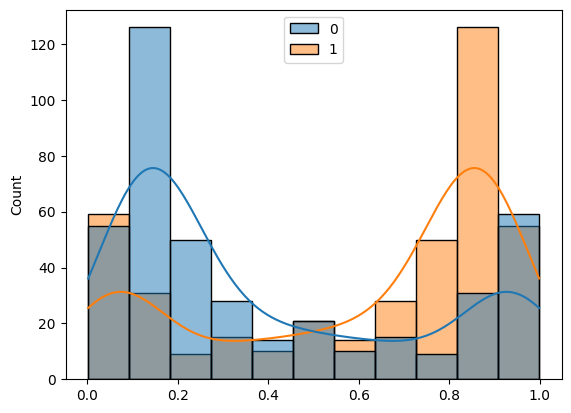

In [516]:

rfc_pred = rfc.predict_proba(X_test)
lr_pred = lr.predict_proba(X_test)
mlpc_pred = mlpc.predict_proba(X_test)
knc_pred = knc.predict_proba(X_test)
gbc_pred = gbc.predict_proba(X_test)
xgb_pred = xgb.predict_proba(X_test)
cat_pred = cat.predict_proba(X_test)
NN_pred = NN.predict(X_test_scaled)
pred_proba = (rfc_pred**2+cat_pred)

# print(pred_proba)
pred = pred_proba.argmax(axis=1)
# print(pred)
print(f"rfc_predのスコアは{kaggle_data_accuracy(rfc_pred)}\n")
print(f"lr_predのスコアは{kaggle_data_accuracy(lr_pred)}\n")
print(f"mlpc_predのスコアは{kaggle_data_accuracy(mlpc_pred)}\n")
print(f"knc_predのスコアは{kaggle_data_accuracy(knc_pred)}\n")
print(f"gbc_predのスコアは{kaggle_data_accuracy(gbc_pred)}\n")
print(f"xgb_predのスコアは{kaggle_data_accuracy(xgb_pred)}\n")
print(f"predのスコアは{kaggle_data_accuracy(pred_proba)}\n")
print(f"NNのスコアは{kaggle_data_accuracy(NN_pred)}\n")
print(f"catのスコアは{kaggle_data_accuracy(cat_pred)}")
sns.histplot(cat_pred, kde = True)

In [517]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission



,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


　提出ファイルを作成するには、このデータフレームのPerishedを上書きするのが手っ取り早いでしょう。

In [518]:
pred.shape

(418,)

In [519]:
if path ==  "/content/drive/My Drive/松尾研/GCI/コンペ１/":
    submission["Perished"] = pred
else:
    submission["Survived"] = pred

print(submission)
#  もしkaggleに提出する場合は以下のコードを実行す
# submission.rename(columns={'Perished': 'Survived'}, inplace=True)
submission

     PassengerId  Perished
0            892         1
1            893         1
2            894         1
3            895         1
4            896         1
..           ...       ...
413         1305         1
414         1306         0
415         1307         1
416         1308         1
417         1309         1

[418 rows x 2 columns]


,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


　これをcsvファイルとして出力すれば、提出ファイルの完成です。\
※csvファイル書き出しの方法は自身の作業場所によって変わります。自分の環境に合わせたコード片方を選択してください。両方または自分の環境外のコードを選択するとエラーが起こります。このnotebookをコピーして用いる場合は下のセルをそのまま実行してください。

In [520]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あ
# submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2024_winter/Competitions/competition_1/submission.csv', index=False)

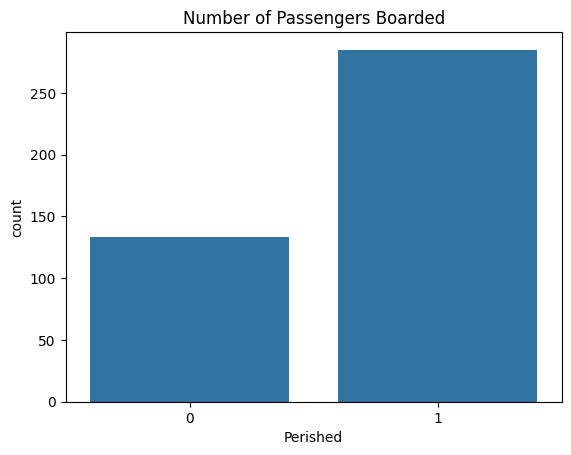

In [521]:
sns.countplot(x=submission.columns[1], data=submission)
plt.title('Number of Passengers Boarded')
plt.show()

In [523]:
# Google Drive・Google Colaboratoryで作業する場

if submission.columns[1] == 'Survived':
    submission.to_csv('submission_to_kaggle_titanic.csv', index=False)
    path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
    correct = pd.read_csv(path + 'correct.csv')
    ans = 0
    for i in range(len(correct)):
      if correct['Survived'][i] == submission['Survived'][i]:
            ans += 1
    print(f"あなたの正解率は{ans/len(correct)}です")
else:
    faile_name = "25.csv"
    submission.to_csv(faile_name,index=False)
    print(submission)
    print(f"{faile_name}をOmnicampusに提出してください")

# from google.colab import files
# files.download('submission.csv')

     PassengerId  Perished
0            892         1
1            893         1
2            894         1
3            895         1
4            896         1
..           ...       ...
413         1305         1
414         1306         0
415         1307         1
416         1308         1
417         1309         1

[418 rows x 2 columns]
25.csvをOmnicampusに提出してください


　この提出ファイルをOmnicampus上で提出してみましょう。本デモンストレーションはこれにて以上です。入門者の方もこのデモンストレーションをベースとするなどし、自分の工夫を一つでも多く加えてみて、スコアと順位の向上を目指してみてください。

#  以下参考にしたサイト一覧

kncの実装：https://qiita.com/kwi0303/items/98d5455db06e82bc7a6d
